In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import cv2
import os
import glob as gb



*   pandas and numpy are used for data manipulation and numerical operations.
*   matplotlib.pyplot helps in plotting graphs and visualizing data.
*   tensorflow and keras are core libraries for building and training deep learning models.
*   ImageDataGenerator from keras is used for data augmentation, a technique to increase the diversity of your training data.
*   cv2 (OpenCV) is used for image processing tasks.
*   os and glob are used for file operations, like navigating directories and handling files.








This code mounts your Google Drive to the Colab environment, allowing access to files stored there.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Starting data prep


This section includes a function load_images_and_labels which loads images from a specified directory and assigns them a label (0 for normal, 1 for cancer).
Images are resized and converted to arrays, forming the input data for the model.
The data is then combined, shuffled, and split into training and testing sets, ensuring a mix of both classes in each set.

In [3]:
#start here
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Paths to your data directories
normal_dir = '/content/drive/MyDrive/rosehackProject/lungData/learningData/train/Normal cases'
cancer_dir = '/content/drive/MyDrive/rosehackProject/lungData/learningData/train/LungCancer'  # This should include both Benign and Malignant images

# Load images and labels
def load_images_and_labels(category_dir, label):
    images = []
    labels = []
    for filename in os.listdir(category_dir):
        if filename.endswith('.jpg') or filename.endswith('.png'):  # Check for image files
            img_path = os.path.join(category_dir, filename)
            img = load_img(img_path, target_size=(64, 64))  # Resize
            img = img_to_array(img)
            images.append(img)
            labels.append(label)
    return images, labels

# Load all images
normal_images, normal_labels = load_images_and_labels(normal_dir, 0)
cancer_images, cancer_labels = load_images_and_labels(cancer_dir, 1)

# Combine data
images = np.array(normal_images + cancer_images)
labels = np.array(normal_labels + cancer_labels)

# Shuffle the data
permutation = np.random.permutation(images.shape[0])
images = images[permutation]
labels = labels[permutation]

# Split data into train and test sets
train_x_orig, test_x_orig, train_y, test_y = train_test_split(images, labels, test_size=0.2, random_state=1)
train_y = train_y.reshape((1, train_y.shape[0]))
test_y = test_y.reshape((1, test_y.shape[0]))


This code flattens the image data. Flattening transforms the 2D image into a 1D array, making it suitable for input into the neural network.
It also normalizes the pixel values by dividing by 255 (the maximum pixel value), so all values are between 0 and 1. This normalization step helps in speeding up the training process and improving performance.

In [4]:
# Flatten the images
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Normalize pixel values
train_x = train_x_flatten / 255.
test_x = test_x_flatten / 255.


This code calculates and prints the number of training and testing examples (m_train and m_test) and the size of the images (num_px). It's crucial to know these dimensions for designing the neural network architecture and ensuring that the data shapes are compatible with the network layers.


In [5]:
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 856
Number of testing examples: 214
Each image is of size: (64, 64, 3)
train_x_orig shape: (856, 64, 64, 3)
train_y shape: (1, 856)
test_x_orig shape: (214, 64, 64, 3)
test_y shape: (1, 214)


n_x is the size of the input layer (number of input features per example).
n_h is the size of the hidden layer (856 units in this case), which is a parameter that can be tuned.
n_y is the size of the output layer. Here, it's 1, indicating a binary classification (cancer or no cancer).
layers_dims is a tuple that holds the dimensions of each layer in the network. This is helpful for initializing parameters and building the layers of the model.

In [6]:
n_x = train_x.shape[0]
n_h = 856
n_y = 1
layers_dims = (n_x, n_h, n_y)

This function initializes the weights and biases for a two-layer neural network (one hidden layer).
W1 and b1 are the weights and biases for the hidden layer, and W2 and b2 are for the output layer.
The weights are initialized randomly to break symmetry, and biases are initialized to zero. Small random values for weights (multiplied by 0.01) help in speeding up the training by ensuring that the neurons initially fire (activate) in a more diverse manner.

In [7]:
def initialize_parameters(n_x, n_h, n_y):
    np.random.seed(2)

    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros(shape=(n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros(shape=(n_y, 1))

    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}

    return parameters

This function implements forward propagation for a linear->activation layer.
A_prev is the activations from the previous layer (or input data), W and b are the weights and biases of the current layer.
Depending on the activation parameter, which can be either "sigmoid" or "relu", this function applies the linear step (calculating Z = W*A_prev + b) and then the activation function.
The output is A, the post-activation value for this layer, and cache, which stores variables used in the calculation for use in backpropagation.

In [8]:
def linear_activation_forward(A_prev, W, b, activation):

    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)

    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)

    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

This function calculates the linear part of a layer's forward propagation.
It takes the activations from the previous layer (A), the weights matrix (W), and the bias vector (b) and computes Z, the pre-activation parameter (essentially Z = W*A + b).
This linear output Z will be passed through an activation function in the next step of forward propagation.

In [9]:
def linear_forward(A, W, b):
    Z = np.dot(W, A) + b

    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)

    return Z, cache

This function is responsible for the backward propagation for a single "linear->activation" layer.
It computes the gradient of the activation function (dA) with respect to the pre-activation (Z), which is necessary for updating the parameters (weights and biases).
Depending on the activation function used (ReLU or Sigmoid), this function will use different methods to calculate the gradient.

In [10]:
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache

    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)

    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
    dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db

relu_backward and sigmoid_backward are functions that compute the gradient of the cost with respect to Z for ReLU and Sigmoid activation functions, respectively.
These gradients are used in the backpropagation process to update the weights and biases in the neural network.

In [11]:
import numpy as np

def sigmoid(Z):

    A = 1/(1+np.exp(-Z))
    cache = Z

    return A, cache

def relu(Z):

    A = np.maximum(0,Z)

    assert(A.shape == Z.shape)

    cache = Z
    return A, cache


def relu_backward(dA, cache):

    Z = cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0

    assert (dZ.shape == Z.shape)

    return dZ

def sigmoid_backward(dA, cache):

    Z = cache

    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)

    assert (dZ.shape == Z.shape)

    return dZ

This function computes the cross-entropy cost, a common cost function used in binary classification problems.
AL represents the probability vector corresponding to the label predictions, and Y is the true "label" vector.
The cost function evaluates how well the model is performing by comparing the predicted output (AL) with the actual labels (Y). The lower the cost, the better the model is at predicting the correct labels.

In [12]:
def compute_cost(AL, Y):

    m = Y.shape[1]
    cost = (-1 / m) * np.sum(np.multiply(Y, np.log(AL)) + np.multiply(1 - Y, np.log(1 - AL)))

    cost = np.squeeze(cost)
    assert(cost.shape == ())

    return cost

This function implements the linear portion of backward propagation for a single layer.
It calculates the gradients of the cost with respect to the linear output of the current layer (dZ), which are needed to update the weights (dW) and biases (db).
cache contains the activations from the previous layer, the weights, and biases of the current layer. These are used to compute the gradients.

In [13]:
def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = np.dot(dZ, cache[0].T) / m
    db = np.squeeze(np.sum(dZ, axis=1, keepdims=True)) / m
    dA_prev = np.dot(cache[1].T, dZ)

    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (isinstance(db, float) or isinstance(db, np.ndarray))

    return dA_prev, dW, db

This function updates the model's parameters using gradient descent, an optimization algorithm used for minimizing the cost function.
It iterates over all layers of the neural network and updates each parameter (W and b) in the direction that reduces the cost, using the gradients computed in backward propagation and a learning rate.

In [14]:
def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent

    Arguments:
    parameters -- python dictionary containing your parameters
    grads -- python dictionary containing your gradients, output of L_model_backward

    Returns:
    parameters -- python dictionary containing your updated parameters
                  parameters["W" + str(l)] = ...
                  parameters["b" + str(l)] = ...
    """

    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * grads["db" + str(l + 1)]

    return parameters

This is the main function for building and training a two-layer neural network (one hidden layer and one output layer).
It includes the entire workflow: initializing parameters, iterating over a number of iterations (epochs), conducting forward and backward propagation, updating parameters, and printing the cost at certain intervals.
The function finally plots the cost over iterations to visualize the learning process and returns the trained parameters.

In [15]:
def two_layer_model(X, Y, layers_dims, learning_rate=0.0075, num_iterations=3000, print_cost=False):

    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims

    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    parameters = initialize_parameters(n_x, n_h, n_y)

    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1". Output: "A1, cache1, A2, cache2".
        A1, cache1 = linear_activation_forward(X, W1, b1, 'relu')
        A2, cache2 = linear_activation_forward(A1, W2, b2, 'sigmoid')

        # Compute cost
        cost = compute_cost(A2, Y)

        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))

        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, 'sigmoid')
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, 'relu')

        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2

        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)

        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]

        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)

    # plot the cost

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    return parameters

This line of code trains the model on the training data (train_x, train_y) using the two_layer_model function.
layers_dims specifies the dimensions of the input layer, hidden layer, and output layer.
num_iterations is the number of times the training process will go through the entire dataset. print_cost=True indicates that the cost will be printed at regular intervals, allowing you to observe the model's learning progress.

Cost after iteration 0: 0.6803545622841304
Cost after iteration 100: 0.5147460845990256
Cost after iteration 200: 0.41097728497846664
Cost after iteration 300: 0.3185074958023731
Cost after iteration 400: 0.23874989295526303
Cost after iteration 500: 0.17808330219171936
Cost after iteration 600: 0.14870398448865435
Cost after iteration 700: 0.10332694802315914
Cost after iteration 800: 0.0816699675533868
Cost after iteration 900: 0.06609031662356071
Cost after iteration 1000: 0.05463111753245245
Cost after iteration 1100: 0.046022781810385924
Cost after iteration 1200: 0.03941601856767316
Cost after iteration 1300: 0.03424241690148084
Cost after iteration 1400: 0.03011796302550295
Cost after iteration 1500: 0.026775712630801963
Cost after iteration 1600: 0.024026686694350215
Cost after iteration 1700: 0.021736146087523844
Cost after iteration 1800: 0.019805042396002805
Cost after iteration 1900: 0.01815954943118277
Cost after iteration 2000: 0.01674371173815644
Cost after iteration 210

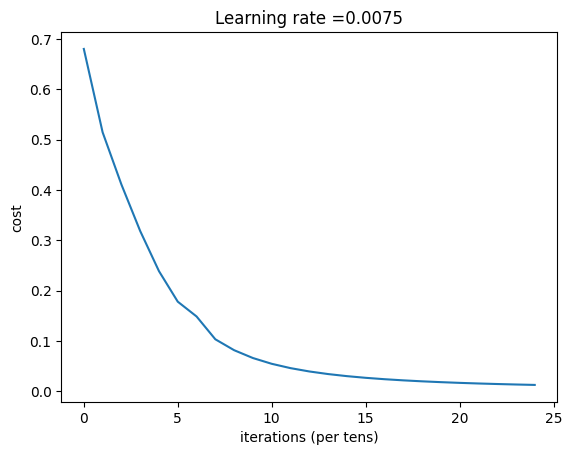

In [16]:
parameters = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)

This code uses the pickle module, a Python library for serializing and deserializing Python object structures, also known as 'pickling' and 'unpickling'.
The trained parameters of the model (parameters) are saved to a file using pickle.dump. This is done in 'write binary' ('wb') mode.
Saving the parameters to a file allows you to use the trained model later without needing to retrain it. You can simply load the parameters from the file and use them for predictions on new data.

In [20]:
import pickle

# Save the parameters to a file
with open('parameters.pkl', 'wb') as file:
    pickle.dump(parameters, file)

The predict function performs forward propagation through a two-layer neural network using the trained parameters (W1, W2, b1, b2) to make predictions on input data X.
It computes the linear transformation for each layer (np.dot(W, X) + b) and applies the appropriate activation function: ReLU for the first layer and Sigmoid for the output layer.
An unconventional approach is used for b1, where the average of each row is taken as the bias due to its atypical shape.
The output of the sigmoid function represents the probabilities, which are converted into binary predictions (0 or 1) based on a threshold of 0.5.
This function encapsulates the neural network's process of predicting whether new input data (X) falls into one of two classes (e.g., cancerous or non-cancerous).

In [29]:
def relu(z):
    return np.maximum(0, z)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def predict(X, parameters):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    # Use the average of each row of b1 as the bias for each neuron
    b1_avg = np.mean(b1, axis=1).reshape(-1, 1)

    # Forward propagation
    Z1 = np.dot(W1, X) + b1_avg
    A1 = relu(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)

    predictions = (A2 > 0.5).astype(int)
    return predictions.flatten()

# Usage example
predictions = predict(test_images_flatten, parameters)

This cell defines a function to load, preprocess, and flatten images from a specified directory, normalizing them for neural network input.
The trained neural network parameters are loaded from the 'parameters.pkl' file using the pickle module.
Cancerous and non-cancerous test images are loaded, labeled appropriately, combined, and shuffled to prepare a test dataset.
The test images are reshaped and fed into a predict function, which uses the loaded parameters to generate predictions.
Finally, the model's performance is evaluated using the classification_report and confusion_matrix functions, providing key metrics like accuracy, precision, and recall.

In [31]:
import numpy as np
import pickle
import os
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.metrics import classification_report, confusion_matrix

# Function to load and preprocess images
def load_and_preprocess_images(image_dir, target_size=(64, 64)):
    images = []
    for filename in os.listdir(image_dir):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            img_path = os.path.join(image_dir, filename)
            img = load_img(img_path, target_size=target_size)
            img = img_to_array(img)
            img = img / 255.0  # Normalization
            img = img.flatten()  # Flatten the image
            images.append(img)
    return np.array(images)

# Load model parameters
with open('parameters.pkl', 'rb') as file:
    parameters = pickle.load(file)


# Load test images
cancerous_images = load_and_preprocess_images('/content/drive/MyDrive/rosehackProject/lungData/learningData/test/LungCancer')
non_cancerous_images = load_and_preprocess_images('/content/drive/MyDrive/rosehackProject/lungData/learningData/test/Normal cases')

# Prepare labels (1 for cancerous, 0 for non-cancerous)
labels = np.concatenate([np.ones(len(cancerous_images)), np.zeros(len(non_cancerous_images))])

# Combine and shuffle images and labels
test_images = np.concatenate([cancerous_images, non_cancerous_images])
permutation = np.random.permutation(len(test_images))
test_images, labels = test_images[permutation], labels[permutation]
test_images_flatten = test_images.reshape(test_images.shape[0], -1).T
# Make predictions
predictions = predict(test_images_flatten, parameters)

# Evaluate the model
print(classification_report(labels, predictions))
print(confusion_matrix(labels, predictions))


              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       207
         1.0       0.99      0.99      0.99       248

    accuracy                           0.99       455
   macro avg       0.99      0.99      0.99       455
weighted avg       0.99      0.99      0.99       455

[[205   2]
 [  3 245]]
